In [10]:
from battery import battery, logger
import numpy as np
import matplotlib.pyplot as plt
import time
%matplotlib inline


#global config
log = logger("differenceSolarConsume", 100)
max_recharge_rate = 7000 # 最大充电速率7kw
max_solar_generation_rate = 20000 # 最大太阳能发20kwh
# batteries = [battery(max_recharge_rate, 100000, 0.96)]
base = "/Users/lishuyu/PycharmProjects/solarPowerEstimate/"
npy = f"{base}npy/"
plot = f"{base}plot/"

solarrad = np.load(npy+"solarrad.npy")

spring24 = np.load(npy+"spring24.npy")
summar24 = np.load(npy+"summer24.npy")
autumn24 = np.load(npy+"autumn24.npy")
winter24 = np.load(npy+"winter24.npy")
spring24 = np.sum(spring24, axis=0)/1000
summar24 = np.sum(summar24, axis=0)/1000
autumn24 = np.sum(autumn24, axis=0)/1000
winter24 = np.sum(winter24, axis=0)/1000


In [11]:
consume = []
for name in [spring24, summar24, autumn24, winter24]:
    for i in range(90):
        consume.append(list(name))
consume = np.array(consume)

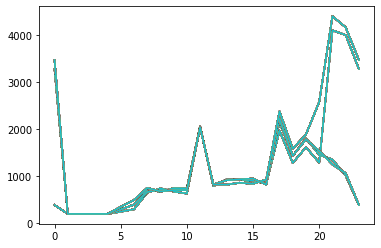

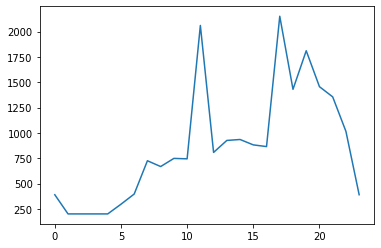

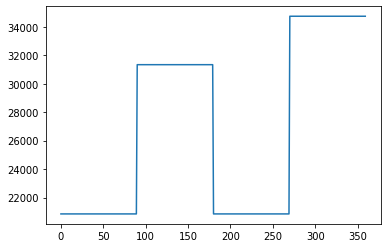

In [12]:
plt.plot(consume.T)
plt.show()
plt.plot(consume[0])
plt.show()
# plt.plot(solarrad[:24]*1000)
plt.plot(np.sum(consume, axis=1))
plt.show()

In [28]:
status = True
current_cap = []
max_nopower_count = 0
power_recharge_rate = 2000
power_capacity = 20000
power_efficency = 0.96
batteries = [battery(power_recharge_rate, power_capacity, power_efficency)]


for hour in range(360*24):
    sum_cap = sum([i.capacity for i in batteries])
    assert sum_cap >= 0
    current_cap.append(sum_cap)
    print(sum_cap, end="\t")

    charge = solarrad[hour] * 1000
    discharge = spring24[hour%24]

    print(charge, discharge)
    # time.sleep(1)
    

    if charge > discharge:
        remain = charge - discharge
        print(f"Charge:{remain}", end="\t")
        for bat in batteries:   remain = bat.charge(remain)

    elif charge < discharge:

        sum_cap_cache = sum_cap
        

        pull = discharge - charge
        print(f"Pull:{pull}", end="\t")
        for bat in batteries:   pull = bat.discharge(pull)
        
        if pull == 0 and not status:
            log.write("count_reset cause pull is zero")
            status = True
            print(f"count_reset cause pull is zero")
            time.sleep
        
        if pull > 0:
            log.write(f"{charge}, {discharge}, {sum([i.capacity for i in batteries])}, note: battery is later for one")
            log.write(f"No avaliable energy on day:{hour//24} hour:{hour}")

            if status:
                max_nopower_count+=1
                log.write("count_increase, set status to false")
                status = False
                print(f"No avaliable energy on day:{hour//24}, {sum([i.capacity for i in batteries])}")
                time.sleep(1)

    else:
        log.write("balance")
    


print(max_nopower_count)

current_cap.append(sum([i.capacity for i in batteries]))

plt.plot(current_cap[-24:], label="battery")
plt.plot(solarrad[hour-24:hour]*1000, label="produce")
new_list = list(spring24)
new_list.extend(new_list)
plt.plot(new_list[hour:hour+24], label="consume")
plt.title(f"Last ppower supply at Day {hour//24} at Hour {hour}")
plt.ylabel("mAh")
plt.xlabel(f"max count{max_nopower_count}; running {hour} hours ({hour//24} days);capacity:{power_capacity};recharge_rate:{power_recharge_rate}", )
plt.legend(loc="upper left")
plt.grid()
log.write(f"Save plot to {plot}Electric_power_capacity_plots/Electric_power_capacity{power_capacity}_PRR_{power_recharge_rate}_{max_nopower_count}.png")
plt.savefig(f"{plot}Electric_power_capacity_plots/Electric_power_capacity{power_capacity}_PRR_{power_recharge_rate}_{max_nopower_count}.png")
plt.show()
#plt.close()

20000	0.0 389.42327806626577
Pull:389.42327806626577	19594.350752014307	0.0 200.0
Pull:200.0	19386.017418680975	0.0 200.0
Pull:200.0	19177.684085347642	0.0 200.0
Pull:200.0	18969.35075201431	0.0 200.0
Pull:200.0	18761.017418680978	0.0 295.59527860099183
Pull:295.59527860099183	18453.105670138277	0.0 396.2302279945563
Pull:396.2302279945563	18040.365849310612	693.1816257767393 724.7998015125778
Pull:31.618175735838463	18007.43024958578	4077.817849342206 667.5145870684872
Charge:3410.3032622737187	20000	7438.4111342510305 748.0159877925421
Charge:6690.395146458488	20000	10803.74528030341 743.6792970262437
Charge:10060.065983277167	20000	14357.359340343037 2060.3382042731814
Charge:12297.021136069856	20000	16824.9775655678 807.054947650221
Charge:16017.922617917578	20000	15794.517532720412 925.281732513861
Charge:14869.235800206552	20000	11709.24975872403 934.653648997838
Charge:10774.596109726193	20000	4348.724200402974 881.3942323239158
Charge:3467.3299680790583	20000	1334.5524119131067

IndexError: index 8015 is out of bounds for axis 0 with size 8015

In [30]:
len(solarrad)//24

333

1 2200
2 2200
3 2200
4 2200
5 2200
6 2200
7 2200
8 2200
9 2200
10 2200
1 2190
2 2190
3 2190
4 2190
5 2190
6 2190
7 2190
8 2190
9 2190
10 2190
1 2180
2 2180
3 2180
4 2180
5 2180
6 2180
7 2180
8 2180
9 2180
10 2180
1 2170
2 2170
3 2170
4 2170
5 2170
6 2170
7 2170
8 2170
9 2170
10 2170
1 2160
2 2160
3 2160
4 2160
5 2160
6 2160
7 2160
8 2160
9 2160
10 2160
1 2150
2 2150
3 2150
4 2150
5 2150
6 2150
7 2150
8 2150
9 2150
10 2150
1 2140
2 2140
3 2140
4 2140
5 2140
6 2140
7 2140
8 2140
9 2140
10 2140
1 2130
2 2130
3 2130
4 2130
5 2130
6 2130
7 2130
8 2130
9 2130
10 2130
1 2120
2 2120
3 2120
4 2120
5 2120
6 2120
7 2120
8 2120
9 2120
10 2120
1 2110
2 2110
3 2110
4 2110
5 2110
6 2110
7 2110
8 2110
9 2110
10 2110


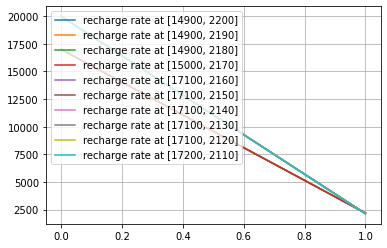

In [12]:
if __name__ == '__main__':
    all_cap = []
    for recharge_rate_var in range(2200, 2100, -10):
        cap = []
        for capacity_var in range(1, 11):
            cap.append([main(capacity_var, recharge_rate_var), recharge_rate_var])
            print(capacity_var, recharge_rate_var)
        all_cap.append(cap)
    for i in all_cap:
        plt.plot(np.array(i).T[0], label = str(np.array(i).T[1][0]), alpha=1)
    plt.legend(loc="upper left")
    plt.grid()
    plt.title(f"compareRelationship_{np.array(i).T[1][0]}")
    plt.savefig(f"{plot}compareRelationship_{np.array(i).T[1][0]}.png")
    plt.show()

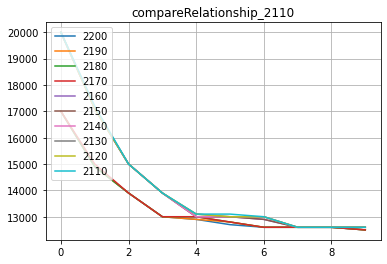